In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import math

In [12]:
def f(x):
    return 3*x**3 -4*x +5

In [13]:
f(3)

74

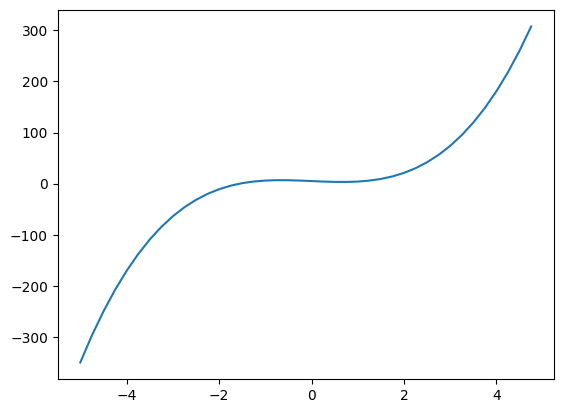

In [14]:
xs=np.arange(-5,5,0.25)
ys=f(xs)
plt.plot(xs,ys)

In [627]:
class Value:
    def __init__(self,data=0,children=(),op=''): 
        self.data=data
        self.children=set(children) #just so that we can keep track of what values are being operated
        self.op=op # keeps track of operation being performed
        self.grad=0.0
        self._backward= lambda : None
        
    def __repr__(self):
        return f"Value(data={self.data})"
        
    def __add__(self,other): #this __add__ just means that whenever two objects are sent with addition in mind (instead of just one parameter) it wont just create the data obj but will add the values of the two objs sent and will create a new obj data
        other= other if isinstance(other,Value) else Value(other) #if other is not an object we wrap it into an object
        out=Value(self.data+other.data,(self,other),'+') 
        def _backward():
            self.grad+=1*out.grad
            other.grad+=1*out.grad
        out._backward=_backward
        return out

    def __radd__(self,other):
        return self+other

    def __neg__(self):
        return self*(-1)

    def __sub__(self,other):
        return self+(-other)

    def __rsub__(self, other):
        return Value(other - self.data)
        
    def __mul__(self,other):
        other= other if isinstance(other,Value) else Value(other)
        out=Value(self.data*other.data,(self,other),'*')
        def _backward():
            self.grad += other.data*out.grad
            other.grad += self.data*out.grad
        out._backward =_backward
        return out

    def __rmul__(self,other):
        return self*other

    def __truediv__(self,other):
        return self*other**(-1)

    def __rtruediv__(self, other):
        return Value(other) * self**(-1)

    def exp(self):
        x=self.data
        out=Value(math.exp(x),(self,),'exp')
        def _backward():
            self.grad+=out.data*out.grad
        out._backward=_backward
        return out
        
    def tanh(self):
        x=self.data
        t= (math.exp(x*2)-1)/(math.exp(x*2)+1)
        out=Value(t,(self,),'tanh')
        def _backward():
            self.grad+=(1-t**2)*out.grad
        out._backward=_backward
        return out

    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
        def _backward():
            self.grad += (out.data > 0) * out.grad
        out._backward = _backward
        return out

    

    def log(self):
        x = self.data
        out = Value(math.log(x), (self,), 'log')
        def _backward():
            self.grad += (1 / x) * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float))
        out=Value(self.data**other,(self,),f'**{other}')
        def _backward():
            self.grad+=other*(self.data**(other-1))*out.grad
        out._backward=_backward
        return out

    def backward(self):
        topo = []
        visited = set()

        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v.children:
                    build_topo(child)
                topo.append(v)

        build_topo(self)

        self.grad = 1.0  
        for node in reversed(topo):
            node._backward()
            

In [615]:
import random
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for _ in range(nin)] # uses random weights from -1 to 1 for each input(nin)
        self.b=Value(random.uniform(-1,1)) #random bias

    def __call__(self,x):
        act=sum((wi*xi for wi,xi in zip(self.w,x)),self.b)
        out=act.tanh()
        return out

    def parameters(self):
        return self.w+[self.b]

class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for i in range(nout)]
    def __call__(self,x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    def parameters(self):
        params=[]
        for neuron in self.neurons:
            ps=neuron.parameters()
            params.extend(ps)
        return params

class MLP:
    def __init__(self,nin,nouts):
        sz=[nin]+nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [616]:
n=MLP(3,[4,4,1])

In [617]:
xs=[[2.0,3.0,-1.0],
   [3.0,-1.0,0.5],
   [0.5,1.0,1.0],
   [1.0,1.0,-1.0]]
ys=[1.0,-1.0,-1.0,1]

In [618]:
for k in range(100):
    # forward pass
    ypred = [n(x) for x in xs]
    ys_val = [Value(y) for y in ys]
    loss = sum((ygt - yout)**2 for ygt, yout in zip(ys_val, ypred))
    for p in n.parameters():
        p.grad = 0.0
    loss.backward()
    for p in n.parameters():
        p.data -= 0.05 * p.grad
    print(k, loss.data)

0 7.3947705767348895
1 7.125434596520856
2 6.5165315689439804
3 4.563626393444218
4 1.707142282788225
5 0.8012484741772468
6 0.4563615305912264
7 0.2997148500530997
8 0.2178755345180841
9 0.1692649578203638
10 0.13753854295684365
11 0.11537829025821356
12 0.09910342816323423
13 0.0866843805373047
14 0.07691847534285147
15 0.06905106389186946
16 0.06258617279288395
17 0.057185162352592904
18 0.052609320732444634
19 0.048685761909330716
20 0.045286332883415825
21 0.04231410748042836
22 0.039694474314201936
23 0.037369099606480397
24 0.035291741585808216
25 0.033425288218124204
26 0.031739621765387464
27 0.0302100536843629
28 0.02881616023449139
29 0.02754090433984112
30 0.02636996506317034
31 0.025291219754578563
32 0.024294339910038106
33 0.023370472715955985
34 0.022511987863960647
35 0.021712274584779576
36 0.02096557768199242
37 0.020266864116525674
38 0.019611713717705183
39 0.018996229092438952
40 0.01841696091977721
41 0.017870845657917665
42 0.017355153328339635
43 0.016867443529

In [619]:
ypred

[Value(data=0.9767738688368606),
 Value(data=-0.9719592351004298),
 Value(data=-0.9481726892286209),
 Value(data=0.951061437346638)]

In [644]:
W1=n.layers[0].neurons[0].w[:]
B=n.layers[0].neurons[0].b
#i need to create a function to return this so that i can use these weights for testing untrained data and predict ypred

[Value(data=-0.14155782667273156), Value(data=0.5417075828953636), Value(data=-0.4678616879087942)]


In [ ]:
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)